In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from glob import glob


from tqdm.notebook import trange
from TaPR_pkg import etapr
from pathlib import Path
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
TRAIN_DATASET = sorted([x for x in Path("./data/235757_HAICon2021_dataset/train").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("./data/235757_HAICon2021_dataset/test").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path("./data/235757_HAICon2021_dataset/validation").glob("*.csv")])

In [5]:
TRAIN_DATASET

[WindowsPath('data/235757_HAICon2021_dataset/train/train1.csv'),
 WindowsPath('data/235757_HAICon2021_dataset/train/train2.csv'),
 WindowsPath('data/235757_HAICon2021_dataset/train/train3.csv'),
 WindowsPath('data/235757_HAICon2021_dataset/train/train4.csv'),
 WindowsPath('data/235757_HAICon2021_dataset/train/train5.csv'),
 WindowsPath('data/235757_HAICon2021_dataset/train/train6.csv')]

In [6]:
def dataframe_from_csv(target):
    return pd.read_csv(target, engine='python').rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [7]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW.head()

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503


In [8]:
TIMESTAMP_FIELD = 'timestamp'
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = 'attack'
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

In [9]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [10]:
def normalize(df):
  normalized_df = df.copy()
  for c in df.columns:
    if TAG_MIN[c] == TAG_MAX[c]:
      normalized_df[c] = df[c] - TAG_MIN[c]
    else:
      normalized_df[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
  return normalized_df

In [11]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [12]:
TRAIN_DF.head()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.433107,0.0,0.056338,0.501686,0.116706,0.447955,0.816071,0.0,0.0,0.0,...,0.240561,0.194185,0.708818,0.183693,0.169066,0.0,0.538147,0.0,0.0,0.276078
1,0.391297,0.0,0.056338,0.519147,0.122242,0.391963,0.816071,0.0,0.0,0.0,...,0.240561,0.194570,0.708818,0.163699,0.168259,0.0,0.538147,0.0,0.0,0.275086
2,0.326466,0.0,0.056338,0.503492,0.141351,0.406353,0.816071,0.0,0.0,0.0,...,0.238072,0.195302,0.708818,0.138395,0.181916,0.0,0.538147,0.0,0.0,0.274857
3,0.458896,0.0,0.056338,0.524326,0.155684,0.440174,0.816071,0.0,0.0,0.0,...,0.236580,0.196575,0.708818,0.123712,0.188038,0.0,0.538147,0.0,0.0,0.277528
4,0.315212,0.0,0.056338,0.517341,0.157428,0.440174,0.816071,0.0,0.0,0.0,...,0.237577,0.196498,0.708818,0.116839,0.187433,0.0,0.538147,0.0,0.0,0.275849


In [13]:
def temporalize(X, y, timesteps):
  output_X = []
  output_y = []
  for i in range(len(X) - timesteps - 1):
    t = []
    for j in range(1, timesteps + 1):
      t.append(X[[i+j+1], :])
    output_X.append(t)
    output_y.append(y[i + timesteps + 1])
  return np.squeeze(np.array(output_X)), np.array(output_y)

In [14]:
train = np.array(TRAIN_DF)
x_train = train.reshape(train.shape[0], 1, train.shape[1])
x_train.shape

(1004402, 1, 86)

In [15]:
def conv_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]

    keras.backend.clear_session()

    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.Dense(128),
            layers.LSTM(
                units=64, activation="relu", name="lstm_1", return_sequences=False
            ),
            layers.Dense(64),
            layers.RepeatVector(n_steps),
            layers.Dense(64),
            layers.LSTM(
                units=64, activation="relu", name="lstm_2", return_sequences=True
            ),
            layers.Dense(128),
            layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.TimeDistributed(layers.Dense(x.shape[2], activation='linear'))
        ]
    )
    return model

In [16]:
model = conv_model(x_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 512)            2818560   
                                                                 
 dense (Dense)               (None, 1, 128)            65664     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 repeat_vector (RepeatVector  (None, 1, 64)            0         
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 1, 64)             4160      
                                                        

In [17]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
            keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

epochs = 5
batch = 64

history = model.fit(x_train, x_train,
                    epochs=epochs, batch_size=batch,
                    validation_split=0.2, callbacks=callbacks).history

model.save('HAI_Autoencoder_LSTM.h5')

Epoch 1/5
12556/12556 [==============================] - 238s 18ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 2/5
12556/12556 [==============================] - 217s 17ms/step - loss: 2.5612e-04 - val_loss: 0.0014
Epoch 3/5
12556/12556 [==============================] - 225s 18ms/step - loss: 3.2260e-04 - val_loss: 9.4651e-04
Epoch 4/5
12556/12556 [==============================] - 236s 19ms/step - loss: 1.5244e-04 - val_loss: 7.1615e-04
Epoch 5/5
12556/12556 [==============================] - 220s 18ms/step - loss: 9.9466e-05 - val_loss: 7.4849e-04


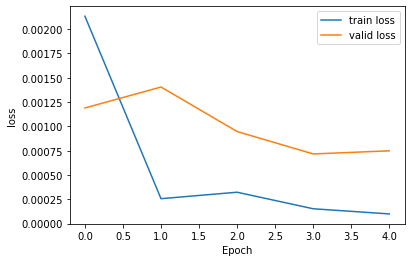

In [18]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [19]:
model = load_model('best_model.h5')

In [20]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW.to_csv('VALIDATION_DF_RAW.csv')
VALIDATION_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,...,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,...,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,...,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,...,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,...,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,...,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
86396,2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,...,31.79738,0.716042,1179.76929,348.03607,1,1018.394040,12.0,50,7,0
86397,2021-07-10 23:59:58,-2.3564,0,12.26196,-0.00101,15.53497,0.2907,12.669310,70,1,...,31.78784,0.716042,1152.66187,348.81366,1,1018.394040,12.0,50,7,0
86398,2021-07-10 23:59:59,-2.1541,0,12.26196,-0.00166,15.53497,0.3280,12.669310,70,1,...,31.77029,0.716042,1130.65723,349.13916,1,1018.394040,12.0,50,7,0


In [21]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

<AxesSubplot:>

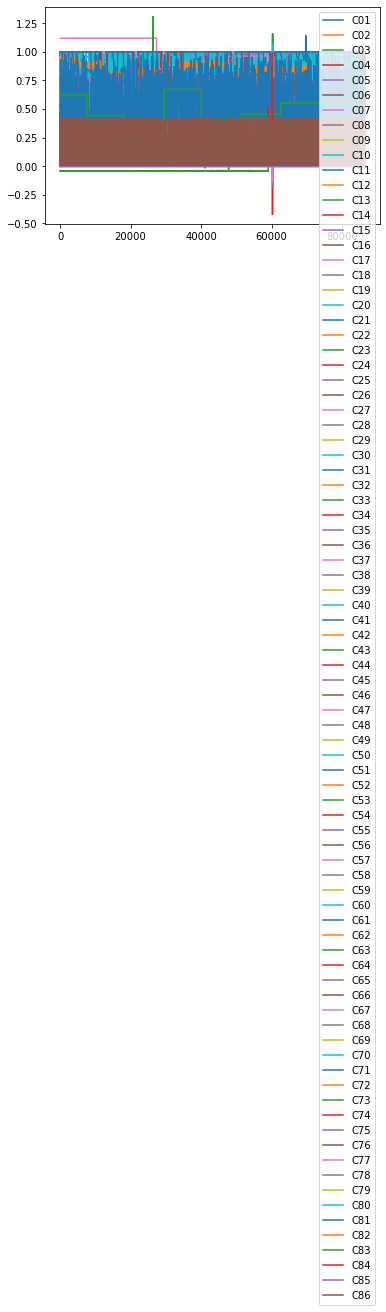

In [22]:
VALIDATION_DF.plot()

<AxesSubplot:>

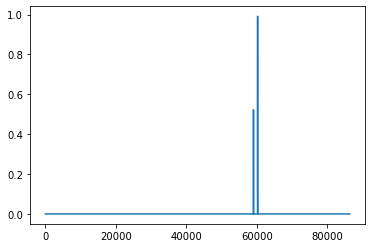

In [23]:
VALIDATION_DF['C84'].plot()

In [24]:
val = np.array(VALIDATION_DF)
x_val = val.reshape(val.shape[0], 1, val.shape[1])
x_val.shape

(86400, 1, 86)

In [25]:
def flatten(X):
  flattened_X = np.empty((X.shape[0], X.shape[2]))
  for i in range(X.shape[0]):
    flattened_X[i] = X[i, (X.shape[1]-1), :]
  return(flattened_X)

def scale(X, scaler):
  for i in range(X.shape[0]):
    X[i, :, :] = scaler.transform(X[i, :, :])

In [26]:
start = time.time()
valid_x_predictions = model.predict(x_val)
print(valid_x_predictions.shape)

error = flatten(x_val) - flatten(valid_x_predictions)
print((flatten(x_val) - flatten(valid_x_predictions)).shape)

valid_mse = np.mean(np.power(flatten(x_val) - flatten(valid_x_predictions), 2), axis=1)
print(valid_mse.shape)
print(valid_mse)
print(time.time() - start)

(86400, 1, 86)
(86400, 86)
(86400,)
[0.00313844 0.00445747 0.00600031 ... 0.00032012 0.00030561 0.00029979]
8.697000503540039


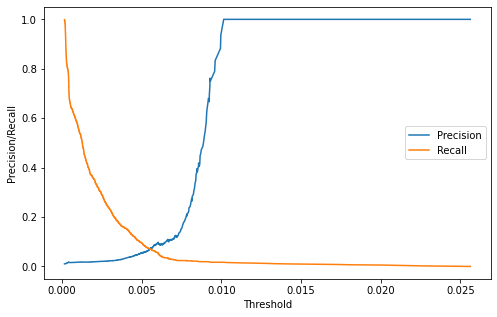

In [27]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse, 
                         'True_class':list(VALIDATION_DF_RAW['attack'])})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [28]:
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.07005649717514124 , recall:  0.07005649717514124
threshold:  0.0055156172804940815
